In [1]:
from scipy.sparse import csr_matrix
import pickle

from utils import *
from multi_threading import read_all_images, parallel_exponentiate_RMS, parallel_sum
from plotting import plot_SUM_or_RMS

# debugging = [True]
array_configs:configDict = dict(debugging=False, 
                  pickle_usage=True, 
                  tiff_amount_cutoff=None
                  )

### Functions

In [2]:
"""
Hello world
"""
# Mirror of sum_array_dense()
# Should create a dense sparse matrix output
@timer_decorator(array_configs)
def get_RMS_array_dense(tiff_path:str, array_configs:configDict) -> np.ndarray:
    """
    Read all images in the `tiff_path`, get `np.ndarray`. Calculate RMS. 
    
    Then convert them to dense.
    """
    pickle_usage = array_configs['pickle_usage']
    debugging = array_configs['debugging']
    
    image_arrays_arr = read_all_images(tiff_path, array_configs)
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            RMS_array = pickle.load(f)
        print('Loaded RMS_image_array.pkl')
    
    else:

        # squaring_start_time = time.time()
        # square = [img.power(2) for img in image_arrays]
        square = parallel_exponentiate_RMS(image_arrays_arr, 2)

        # squaring_end_time = time.time()
        # if debugging==True:
        #     print(f'Squaring time: {squaring_end_time - squaring_start_time:.1f} seconds. With {get_def_name()}')


        # adding_start_time = time.time()
        # RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)
        RMS_array_arr:np.ndarray = np.sqrt(parallel_sum(square) / len(square))

        # adding_end_time = time.time()
        # if debugging==True:
        #     print(f'Adding time: {adding_end_time - adding_start_time:.1f} seconds. With {get_def_name()}')

        if debugging==True:
            # print(f'Total RMS_array elements: {RMS_array_csr.size}')    # 开什么玩笑，要吐了！应该直接取Image Dimension!
            _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]
            total_pixel_amount = image_width * image_length
            print(f'Total RMS_array elements: {total_pixel_amount}')
            print(f'Non-zero RMS_array elements: {RMS_array_arr.nnz}')
            print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_arr.nnz}')


        RMS_array:np.ndarray = RMS_array_arr
        if pickle_usage==True:
            with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
                pickle.dump(RMS_array, f)

            # with open(f'{tiff_path}\\RMS_image_array_csr.pkl', 'wb') as f:
            #     pickle.dump(RMS_array_csr, f)

    return RMS_array


def get_camera_RMS(RMS_array:np.ndarray) -> float:
    """
    RMS_array is an array of pixel RMSs
    Calculating RMS of `RMS_array` is the same as calculating RMS for `img_arrays`
    """
    return np.sqrt(np.mean(RMS_array**2))


### Testing

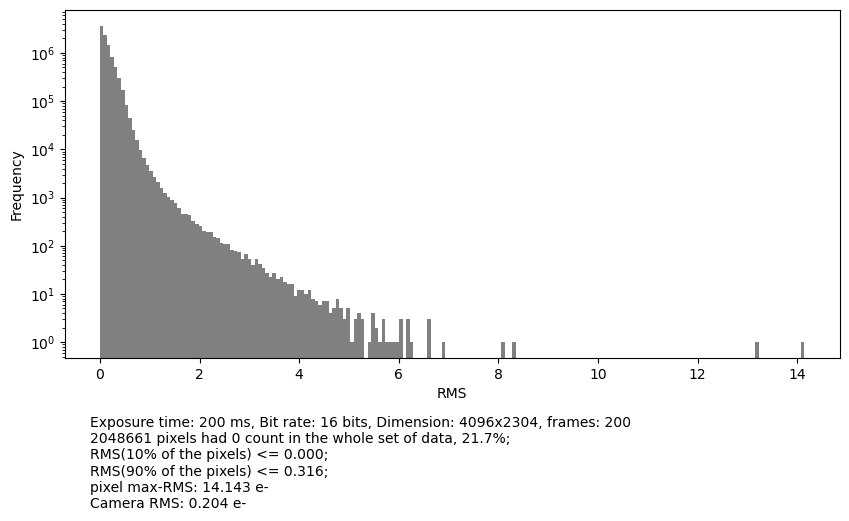

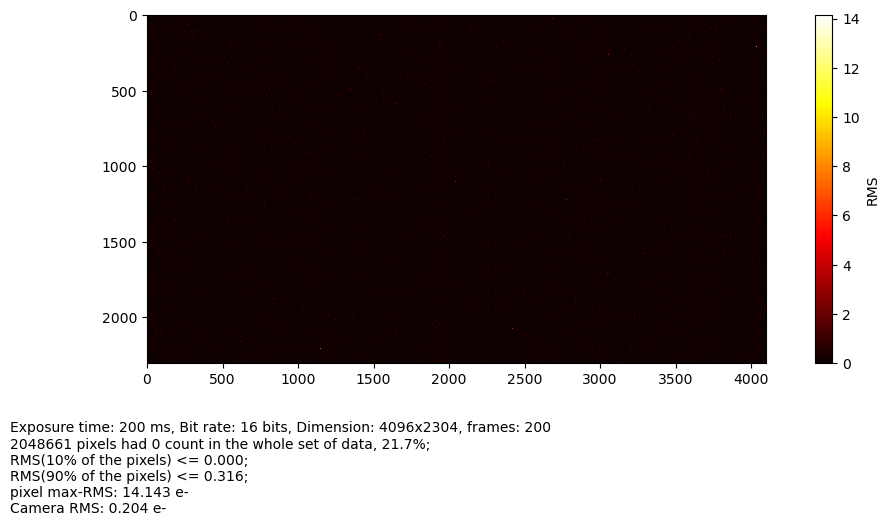

In [6]:
tiff_main_folder = 'C:\\LABDATA_office\\3.12 qCMOS'
# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# tiff_path = tiff_main_folder + '\\full_5s_2000shots'
# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
# tiff_path = tiff_main_folder + '\\1024x1024_quick'
# tiff_path = 'C:\\Users\\Soyo\\OneDrive\\LABDATA\\3.25 laser fluctuation with qCMOS\\qCMOS'


RMS_array = get_RMS_array_dense(tiff_path, array_configs)

plot_configs:plotDict = dict(
                            array_type = 'RMS', 
                            bin_amount = 200, 
                            heatmap_max = None, 
                            dpi = 100, 
                            save = False
                            )


plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_configs, 'bar')
plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_configs, 'heat')
# plot_SUM_or_RMS(RMS_array, tiff_path, array_configs, plot_type='heat', array_type='RMS', save=True)